# MICROPROBING 

In [ ]:
# # NOTE -> log likelihood is slightly different for microprobing vs the more general case 
# # because for microprobing at the momemnt i'm running "beta" and "slope" as a GLM outside MCMC
# This won't work here - it is copy and pasted from micro_probe.py for reference only
def ln_likelihood(self, params, response):
    '''Log likelihood
    DODGY - ASK REMCO
    '''
    # Get the predicted time series
    pred = self.prfpy_model.return_prediction(
        mu_x=np.array([params[0]]),
        mu_y=np.array([params[1]]),
        size=np.array([self.tiny_prf_size]),
        beta=np.array([1]), # beta is the amplitude of the response
        baseline=np.array([0]),
    )
    # Estimate slope and offset using calssical GLM and OLS
    # THIS IS DIFFERENT FROM prf_bayes (where we fit the slope and offset inside MCMC)
    m_response = np.mean(response)
    m_pred = np.mean(pred)
    slope = np.sum((response - m_response) * (pred - m_pred)) / np.sum((pred - m_pred) **2)
    offset = m_response - slope * m_pred
    pred = pred * slope + offset

    # Calculate log likelihood
    residuals = response - pred        
    # Estimate mean and std of the residuals (assuming normal distribution)
    # -> check for nonfinite values 
    try:        
        muhat, sigmahat = stats.norm.fit(residuals.squeeze())
    except:
        # In case of invalid output
        return -np.inf # If there are non-finite values, return a small value
    
    # Check if the spread is valid
    if sigmahat <= 0:
        return -np.inf
    
    # Calculate the log likelihood of the residuals
    # given the fitted normal distribution (feels a bit circular?)
    # then add it up for all time points
    log_like = stats.norm.logpdf(residuals, muhat, sigmahat).sum()

    return log_like

Before running this notebook - install this package
(i.e., in the terminal, inside this folder run:
"pip install -e .")

You also need: 

* emcee               https://emcee.readthedocs.io/en/stable/user/install/

* prfpy               https://github.com/VU-Cog-Sci/prfpy.git (or https://github.com/spinoza-centre/prfpy_csenf.git if you want the contrast sensitivity function.)

* dag_prf_utils       https://github.com/mdaghlian/dag_prf_utils.git


Also a bit of an apology... There is some inconsistency in naming between prfpy and dag_prf_utils. I promise there is a good reason for this. I want prfpy to be backwards compatible. But, some names interfere with each other, when you start including other models (e.g., size, compared to size_1, and size_2 in the DN model). Here is the mapping for the gaussian model:

```
prfpy       dag_prf_utils

mu_x        x
mu_y        y
size        size_1
beta        amp_1
baseline    bold_baseline
hrf_1       hrf_deriv
hrf_2       hrf_disp


```

Most of the time you shouldn't have to think about it...

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


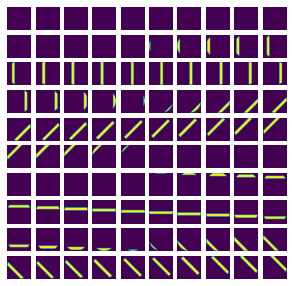

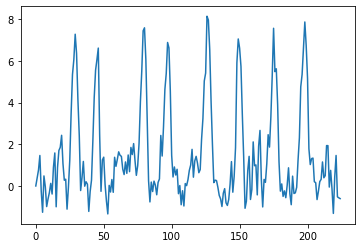

In [ ]:
%load_ext autoreload
%autoreload 2
import numpy as np
import matplotlib.pyplot as plt
try:
    from prfpy.stimulus import PRFStimulus2D
    from prfpy.model import Iso2DGaussianModel
except:
    from prfpy_csenf.stimulus import PRFStimulus2D
    from prfpy_csenf.model import Iso2DGaussianModel
import os
import yaml
import pickle
from datetime import datetime

# If you already have the design matrix as a numpy array, you can simply load it...
dm = np.load('./design_matrix.npy')

# You can see we have a binarized matrix, of a bar moving across the screen...
fig = plt.figure()
rows = 10
cols = 10
fig.set_size_inches(5,5)
for i in range(100):
    ax = fig.add_subplot(rows, cols, i+1)
    ax.imshow(dm[:,:,i], vmin=0, vmax=1)
    ax.axis('off')
# Now we need to enter the design matrix in a way that prfpy can read it. 
# If for some reason you do not have the original dimensions, but you do have the dov, you can use this calculator:
# https://elvers.us/perception/visualAngle/ to make up some values for screen_size and distance, which will work...
prf_stim = PRFStimulus2D(
    screen_size_cm=39.3,          # Distance of screen to eye
    screen_distance_cm=196,  # height of the screen (i.e., the diameter of the stimulated region)
    design_matrix=dm,                                   # dm (npix x npix x time_points)
    TR=1.5,                                  # TR
    )
# Now we can make the model
model = 'gauss'
# HRF is determined by coefficients for the canonical HRF, its time derivative, and its dispersion derivative
# Here we set it at 1, 4.6 and 0 (what we have found to work at spinoza)
prfpy_model = Iso2DGaussianModel(stimulus=prf_stim, hrf=[1, 4.6, 0]) 


# Load the runs

psc_runs = np.load('eg_data.npy')
# Show an example
plt.figure()
plt.plot(psc_runs[0,:])

# Metropolis Hastings - with MCMC 

In [11]:
from prfpy_bayes.micro_probe import MicroProbe
bprf = MicroProbe(
    prfpy_model = prfpy_model,  # prfpy model objects
    real_ts = psc_runs,         # time series (data)
    bounds = [-5,5],            # bounds for x,y
    tiny_prf_size = 0.01,       # tiny prf size     
)

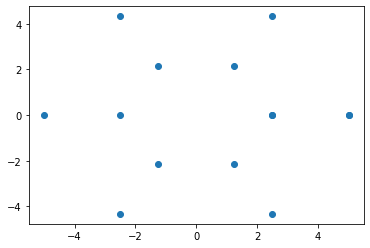

In [12]:
import emcee
# Some starting poisitions... (a bit random - but lets go for it for now)
pol = np.linspace(0, 2*np.pi, 7)
ecc = np.array([2.5, 5]) # , 2,3, 4,])
pol,ecc = np.meshgrid(pol, ecc)
x,y = ecc*np.cos(pol), ecc*np.sin(pol)
x,y = x.flatten(), y.flatten()
plt.scatter(x,y)
walkers = np.array([x,y]).T


In [13]:
# Lets run the fitting for voxel 0
# -> need to specify the "move", i.e., how it makes steps
import emcee 
moves = emcee.moves.GaussianMove(cov=.5, mode='vector') # Setting cov=.1 for a small step size
# From EMCEE documentation
"""A Metropolis step with a Gaussian proposal function.

Args:
    cov: The covariance of the proposal function. This can be a scalar,
        vector, or matrix and the proposal will be assumed isotropic,
        axis-aligned, or general respectively.
    mode (Optional): Select the method used for updating parameters. This
        can be one of ``"vector"``, ``"random"``, or ``"sequential"``. The
        ``"vector"`` mode updates all dimensions simultaneously,
        ``"random"`` randomly selects a dimension and only updates that
        one, and ``"sequential"`` loops over dimensions and updates each
        one in turn.
    factor (Optional[float]): If provided the proposal will be made with a
        standard deviation uniformly selected from the range
        ``exp(U(-log(factor), log(factor))) * cov``. This is invalid for
        the ``"vector"`` mode.

Raises:
    ValueError: If the proposal dimensions are invalid or if any of any of
        the other arguments are inconsistent.

"""

# We also need to include the argument "skip_initial_state_check" in the kwargs_run
# This is because the default "move" in emcee needs a minimum number of walkers 
# but we are using the GaussianMove which does not have this requirement
n_steps = 500
bprf.run_mcmc_fit(
    idx=0,                      # Index of the vertex times series to fit     
    n_walkers=len(walkers),     # Number of walkers (i.e., starting points)
    walkers=walkers,            # Starting points
    n_steps=n_steps,                # How many steps to takes
    kwargs_sampler={'moves':moves},  # Arguments for the sampler
    kwargs_run = {'skip_initial_state_check':True},        
)

/data1/projects/dumoulinlab/Lab_members/Marcus/programs/prfpy_bayes/prfpy_bayes/micro_probe.py:66: RuntimeWarning: invalid value encountered in scalar divide
  slope = np.sum((response - m_response) * (pred - m_pred)) / np.sum((pred - m_pred) **2)
/data1/projects/dumoulinlab/Lab_members/Marcus/programs/prfpy_bayes/prfpy_bayes/micro_probe.py:66: RuntimeWarning: invalid value encountered in scalar divide
  slope = np.sum((response - m_response) * (pred - m_pred)) / np.sum((pred - m_pred) **2)
/data1/projects/dumoulinlab/Lab_members/Marcus/programs/prfpy_bayes/prfpy_bayes/micro_probe.py:66: RuntimeWarning: invalid value encountered in scalar divide
  slope = np.sum((response - m_response) * (pred - m_pred)) / np.sum((pred - m_pred) **2)
/data1/projects/dumoulinlab/Lab_members/Marcus/programs/prfpy_bayes/prfpy_bayes/micro_probe.py:66: RuntimeWarning: invalid value encountered in scalar divide
  slope = np.sum((response - m_response) * (pred - m_pred)) / np.sum((pred - m_pred) **2)
/data1/p

prf_params.shape[-1]=8
include hrf = True
include rsq = True


Ok hopefully that all ran! 

Lets look at what we got out!

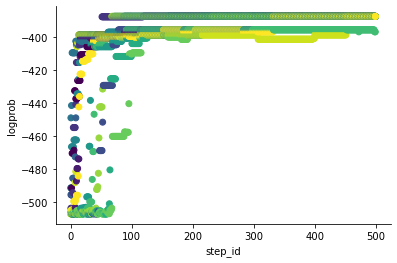

In [14]:
# All the information for the fitting is stored in the object
# Lets have a look, does logprobability improve over time (it should!!)
bprf.sampler[0].scatter( # I have a bunch of functions for plotting useful PRF info
    px='step_id',  # Step number 
    py='logprob',  # Log probability
    pc='walker_id', # Lets color the points differently depending on start position
    th={},         # No need for thresholding, include everything!!
)
# Ok most things get better!


In [15]:
# All the information for every microprobe is stored in the object
bprf.sampler[0].pd_params # This is a pandas dataframe with all the parameters

,x,y,size_1,amp_1,bold_baseline,hrf_deriv,hrf_disp,rsq,ecc,pol,clock,logprob,walker_id,step_id
0,2.500000,0.000000,0.01,5.664822e+07,1.345564,4.6,0.0,0.131262,2.500000,0.000000,3.000000,-491.542996,0,0
1,1.095474,2.945766,0.01,4.385763e-01,1.498489,4.6,0.0,0.003089,3.142865,1.214763,5.320027,-507.025278,1,0
2,-2.056845,-0.194466,0.01,2.236551e+03,1.435862,4.6,0.0,0.030997,2.066017,-3.047327,9.180034,-503.830964,2,0
3,-1.980362,0.360004,0.01,1.958109e+08,1.481796,4.6,0.0,0.007949,2.012818,2.961770,8.656563,-506.475411,3,0
4,-1.429054,-2.075698,0.01,5.334413e+06,1.367216,4.6,0.0,0.098830,2.520063,-2.173741,10.848460,-495.666440,4,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
6995,0.890873,-0.848235,0.01,4.640837e+02,1.107389,4.6,0.0,0.625833,1.230105,-0.760886,1.546814,-396.779952,9,499
6996,0.817055,-1.198029,0.01,5.608496e+06,1.084265,4.6,0.0,0.655863,1.450122,-0.972253,1.143133,-387.367654,10,499
6997,0.905652,-1.288223,0.01,4.253003e+07,1.084265,4.6,0.0,0.655860,1.574714,-0.958043,1.170272,-387.368850,11,499
6998,0.835192,-1.295623,0.01,3.080309e+05,1.084265,4.6,0.0,0.655860,1.541487,-0.998208,1.093563,-387.368850,12,499


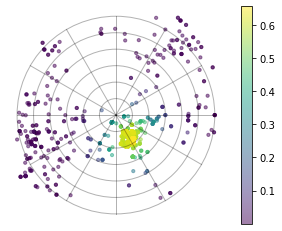

In [16]:
# Lets look at the visual field coverage
bprf.sampler[0].visual_field( # Another one of my plotting functions!
    dot_col='rsq',  # Color the dots by the r squared value
    dot_size=10,   # Size of the dots
    th={},        # No thresholding
)

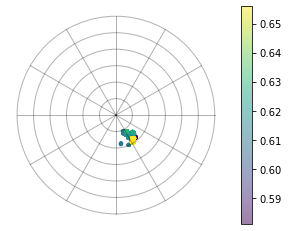

In [17]:
# Lets look at the visual field coverage, but with some burn in
bprf.sampler[0].visual_field( # Another one of my plotting functions!
    dot_col='rsq',  # Color the dots by the r squared value
    dot_size=10,   # Size of the dots
    th={
        'min-step_id' : 100,  # Only include steps after 100
    },        # No thresholding
)